In [57]:
import sys
print(sys.version)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


In [58]:
# Importing dependencies

import numpy as np
np.random.seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
import datetime as dt
import time
import yfinance as yf
plt.style.use('ggplot')

### Data Preprocessing

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

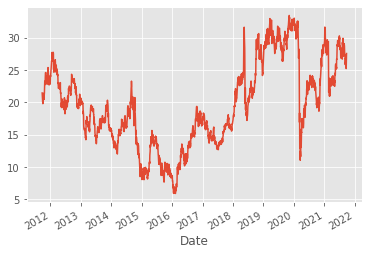

In [59]:
# Loading the dataset
p = '10y'
i = '1d'

df = yf.download(tickers='petr3.sa', period = p, interval = i)
df.drop(df[df['Volume']==0].index, inplace = True)
df['Close'].plot()

In [60]:
# Correlation matrix
df.corr()['Close']

Open         0.997818
High         0.998927
Low          0.999088
Close        1.000000
Adj Close    0.991137
Volume      -0.071804
Name: Close, dtype: float64

In [61]:
print(df.describe().Volume) 
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    2.454000e+03
mean     1.356988e+07
std      1.281893e+07
min      1.610000e+04
25%      6.985425e+06
50%      1.046900e+07
75%      1.619740e+07
max      3.104194e+08
Name: Volume, dtype: float64


In [62]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [63]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']


In [64]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    mae = mean_absolute_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mae, mse, rmse, r2, Y_test, Y_hat

In [65]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'g')
    plt.xlabel('Dia')
    plt.ylabel('Preço normalizado')
    #plt.title("Stock Price Prediction using Univariate-LSTM")
    plt.legend(['Atual','Predito'],loc = 'lower right')
    plt.show()

In [66]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [67]:
# Função para transformar dados em sequencia do LSTM
def to_sequential_data(data, timesteps):
    x,y = [],[]
    for i in range(timesteps,data.shape[0]):
        x.append(data[i-timesteps:i])
        y.append(data[i])
    return np.array(x),np.array(y)

### Model Building

In [68]:
# Extracting the series
features = ['Close', 'Open', 'Low', 'High']
series = df[features] # Picking the series with high correlation
print(series.shape)
print(series.tail())

(2454, 4)
                Close       Open        Low       High
Date                                                  
2021-09-20  25.230000  24.840000  24.500000  25.240000
2021-09-21  25.629999  25.480000  25.160000  25.840000
2021-09-22  26.459999  25.940001  25.940001  26.740000
2021-09-23  27.559999  26.459999  26.459999  27.559999
2021-09-24  27.559999  27.350000  27.150000  27.840000


In [69]:
# Train Val Test Split
qt_teste = 300

train_data =  series.iloc[:-(qt_teste*2),]
val_data = series.iloc[-(qt_teste*2):-qt_teste,]
test_data = series.iloc[-qt_teste:]

print(train_data.shape,val_data.shape,test_data.shape)

(1854, 4) (300, 4) (300, 4)


In [70]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(1854, 4) (300, 4) (300, 4)


In [71]:
timesteps = 25
hl = [50,35]
lr = 1e-3
batch_size = 64
num_epochs = 250

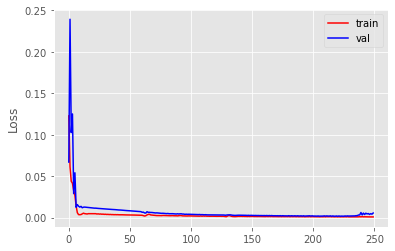

In [72]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MAE = 0.025257562950303774
MSE = 0.0011318729481875139
RMSE = 0.033643319517959486
R-Squared Score = 0.9228042938058012


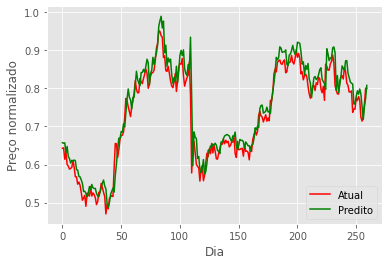

In [73]:
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,40)
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

In [74]:
# Save a model
model.save('MV3-LSTM_50_[40,35]_1e-3_64.h5')
del model # Deletes the model
# Load a model
model = load_model('MV3-LSTM_50_[40,35]_1e-3_64.h5')

## Cross-Validation

In [75]:
# Hyperparameters
timesteps = 25
hl = [50,35]
lr = 1e-3
batch_size = 64
num_epochs = 50

In [76]:
# Extracting the series
series = df[features] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(2454, 4)
                Close       Open        Low       High
Date                                                  
2021-09-20  25.230000  24.840000  24.500000  25.240000
2021-09-21  25.629999  25.480000  25.160000  25.840000
2021-09-22  26.459999  25.940001  25.940001  26.740000
2021-09-23  27.559999  26.459999  26.459999  27.559999
2021-09-24  27.559999  27.350000  27.150000  27.840000


In [77]:
# Normalisation
sc = MinMaxScaler()
series = sc.fit_transform(series[:series.shape[0]])
series

array([[0.56463321, 0.59424567, 0.58207309, 0.58246116],
       [0.55555551, 0.58281079, 0.5732202 , 0.56694336],
       [0.55192448, 0.57395798, 0.56953159, 0.56153009],
       ...,
       [0.74618731, 0.73957951, 0.74769463, 0.74882711],
       [0.78612923, 0.75876057, 0.76687569, 0.7784193 ],
       [0.78612923, 0.79158983, 0.79232758, 0.78852398]])

### Split I

In [78]:
#Splitting the data for initial model creation
splits = 5
split_size = 300

cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()

Split 1
MAE = 0.014974742998434678
MSE = 0.00033517357766394356
RMSE = 0.018307746384084077
R-Squared Score = 0.942894262202315


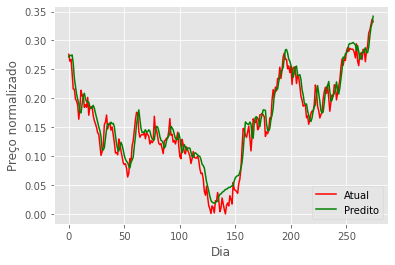

In [79]:
train = series[:3*split_size]
test = series[3*split_size:4*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,shuffle = False)
end = time.time()   

train_loss['Split1'] =  history.history['loss']
val_loss['Split1'] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 1")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV3-LSTM-Split1.h5")

### Split II

Split 2
MAE = 0.011270958920481036
MSE = 0.00022396789012064068
RMSE = 0.014965556792870777
R-Squared Score = 0.9412550107712269


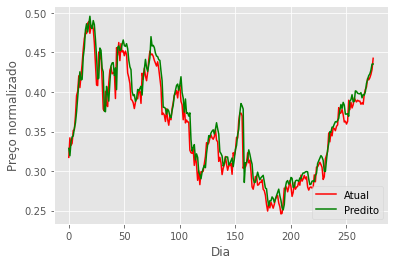

In [80]:

train = series[:4*split_size]
test = series[4*split_size:5*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split2"] = history.history['loss']
val_loss["Split2"] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 2")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV3-LSTM-Split2.h5")

### Split III

Split 3
MAE = 0.02100931165825018
MSE = 0.0009294157976240976
RMSE = 0.030486321483972078
R-Squared Score = 0.951869089004653


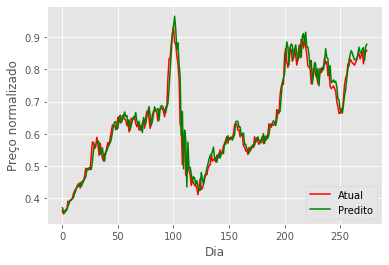

In [81]:
train = series[:5*split_size]
test = series[5*split_size:6*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split3"] = history.history['loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 3")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV3-LSTM-Split3.h5")

### Split IV

Split 4
MAE = 0.034365121279472825
MSE = 0.0019481067422959697
RMSE = 0.04413736220364749
R-Squared Score = 0.9424545396709919


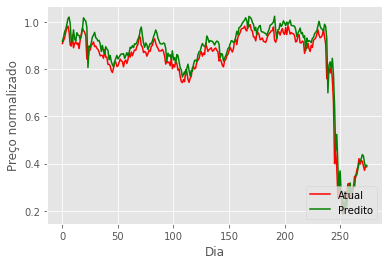

In [82]:
train = series[:6*split_size]
test = series[6*split_size:7*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split4"] = history.history['loss']
val_loss["Split4"] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 4")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV3-LSTM-Split4.h5")

### Split V

Split 5
MAE = 0.019537045304074484
MSE = 0.0007301254645678217
RMSE = 0.027020833898453646
R-Squared Score = 0.9437863563077951


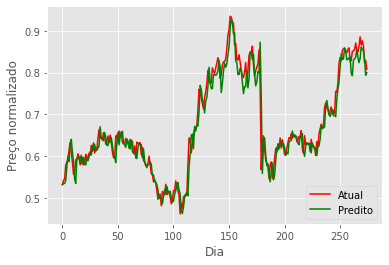

In [83]:
train = series[:7*split_size]
test = series[7*split_size:8*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split5"] = history.history['loss']
val_loss["Split5"] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 5")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV3-LSTM-Split5.h5")

In [84]:
CV_temp = pd.DataFrame(cross_val_results,columns=['MAE', 'MSE','RMSE','R2_Score','Train_Time'])
print("Avg. MAE = {}".format(CV_temp['MAE'].mean()))
print("Avg. MSE = {}".format(CV_temp['MSE'].mean()))
print("Avg. RMSE = {}".format(CV_temp['RMSE'].mean()))
print("Avg. R2-score = {}".format(CV_temp['R2_Score'].mean()))
cross_val_results.append([CV_temp['MAE'].mean(), CV_temp['MSE'].mean(),CV_temp['RMSE'].mean(),CV_temp['R2_Score'].mean()])
cross_val_results.append([CV_temp['MAE'].std(), CV_temp['MSE'].std(),CV_temp['RMSE'].std(),CV_temp['R2_Score'].std()])
CV_results = pd.DataFrame(cross_val_results,columns=['MAE', 'MSE','RMSE','R2_Score', 'Train_Time'])

Avg. MAE = 0.02023143603214264
Avg. MSE = 0.0008333578944544947
Avg. RMSE = 0.026983564152605617
Avg. R2-score = 0.9444518515913962


In [85]:
CV_results.to_csv('LSTM-M PETR3.csv')
#train_loss.to_csv('PETR_MV3-LSTM_CrossValidation_TrainLoss.csv')
#val_loss.to_csv('PETR_MV3-LSTM_CrossValidation_ValLoss.csv')